In [13]:
!pip -q install requests beautifulsoup4 pandas lxml tqdm

In [14]:
import re
import time
import random
import urllib.parse
from collections import Counter

import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

import matplotlib.pyplot as plt

In [15]:
BASE_URL = "https://realpython.github.io/fake-jobs/"

headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome Safari"
}

def get_soup(url):
    r = requests.get(url, headers=headers, timeout=20)
    r.raise_for_status()
    return BeautifulSoup(r.text, "lxml")

soup = get_soup(BASE_URL)

# Each job lives inside a Bulma "card"
cards = soup.select("div.card")
len(cards)


100

In [16]:
rows = []

for card in tqdm(cards):
    # Main fields from the card body
    content = card.select_one("div.card-content")
    if content is None:
        continue

    title_el = content.select_one("h2.title")
    company_el = content.select_one("h3.subtitle")
    location_el = content.select_one("p.location")
    time_el = content.select_one("time")

    title = title_el.get_text(strip=True) if title_el else None
    company = company_el.get_text(strip=True) if company_el else None
    location = location_el.get_text(strip=True) if location_el else None

    # date as text or datetime attribute
    if time_el and time_el.has_attr("datetime"):
        posted_date = time_el["datetime"].strip()
    else:
        posted_date = time_el.get_text(strip=True) if time_el else None

    # Find a link to the detail page from the card footer
    footer = card.select_one("footer.card-footer")
    detail_url = None
    if footer:
        # prefer the link that says Learn more
        link = None
        for a in footer.select("a[href]"):
            txt = (a.get_text() or "").lower()
            if "learn" in txt:
                link = a
                break
        if link is None and footer.select_one("a[href]"):
            link = footer.select_one("a[href]")
        if link:
            detail_url = urllib.parse.urljoin(BASE_URL, link["href"])

    # Get description text from detail page if present
    description = None
    if detail_url:
        try:
            detail_soup = get_soup(detail_url)
            # take main content block
            desc_el = detail_soup.select_one("div.content")
            if desc_el:
                description = desc_el.get_text(" ", strip=True)
            time.sleep(random.uniform(0.3, 0.8))  # polite delay
        except Exception as e:
            description = None

    rows.append({
        "job_title": title,
        "company": company,
        "location": location,
        "posted_date": posted_date,
        "detail_url": detail_url,
        "description": description
    })

len(rows)


100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


100

In [17]:
df = pd.DataFrame(rows)

# basic clean
df = df.drop_duplicates().reset_index(drop=True)

# split city and state if format is "City, ST"
def split_city(loc):
    if not isinstance(loc, str):
        return None
    return loc.split(",")[0].strip()

df["city"] = df["location"].apply(split_city)

df.head(3)


,job_title,company,location,posted_date,detail_url,description,city
0,Senior Python Developer,"Payne, Roberts and Davis","Stewartbury, AA",2021-04-08,https://www.realpython.com,None,Stewartbury
1,Energy engineer,Vasquez-Davidson,"Christopherville, AA",2021-04-08,https://www.realpython.com,None,Christopherville
2,Legal executive,"Jackson, Chambers and Levy","Port Ericaburgh, AA",2021-04-08,https://www.realpython.com,None,Port Ericaburgh


In [18]:
skill_list = [
    "python","sql","excel","power bi","tableau","pandas","numpy","matplotlib","seaborn",
    "machine learning","deep learning","nlp","statistics","scikit-learn","spark",
    "django","flask","fastapi",
    "javascript","react","node","html","css",
    "java","c++","c#","go","rust",
    "aws","azure","gcp","docker","kubernetes","git","linux",
    "communication","leadership","problem solving"
]

# prebuild regex for each skill
compiled = []
for s in skill_list:
    # escape special chars like c++
    pattern = r"\b" + re.escape(s) + r"\b"
    compiled.append((s, re.compile(pattern, flags=re.IGNORECASE)))

def extract_skills(text):
    if not isinstance(text, str):
        return []
    found = []
    for name, rx in compiled:
        if rx.search(text):
            found.append(name.lower())
    return sorted(set(found))

# search in title + description
df["text_for_skills"] = (
    df["job_title"].fillna("") + " " + df["description"].fillna("")
)
df["skills_found"] = df["text_for_skills"].apply(extract_skills)

df[["job_title","city","skills_found"]].head(5)


,job_title,city,skills_found
0,Senior Python Developer,Stewartbury,[python]
1,Energy engineer,Christopherville,[]
2,Legal executive,Port Ericaburgh,[]
3,Fitness centre manager,East Seanview,[]
4,Product manager,North Jamieview,[]


In [19]:
top_roles = (
    df["job_title"]
    .dropna()
    .str.strip()
    .value_counts()
    .head(15)
)
top_roles


,count
job_title,
Python Programmer (Entry-Level),3
Legal executive,2
Materials engineer,2
Software Developer (Python),2
Manufacturing systems engineer,2
"Back-End Web Developer (Python, Django)",2
Futures trader,2
Textile designer,1
Product manager,1


In [20]:
all_skills = [s for lst in df["skills_found"] for s in lst]
skill_counts = Counter(all_skills)
pd.Series(dict(skill_counts)).sort_values(ascending=False).head(20)


,0
python,10
django,2


**Bonus charts**

Top skills overall

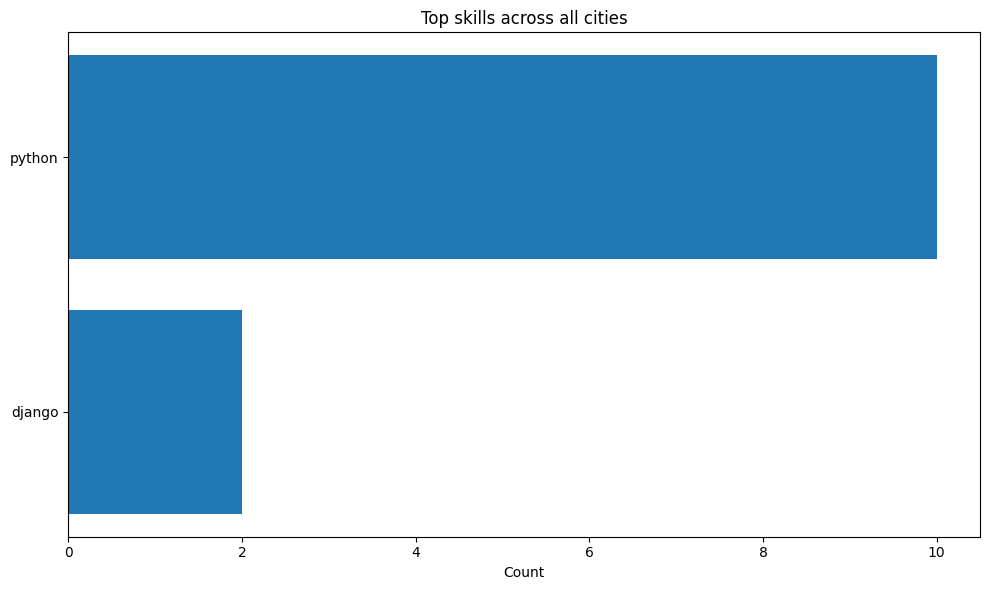

In [21]:
top_k = 15
top_items = pd.Series(dict(skill_counts)).sort_values(ascending=False).head(top_k)

plt.figure(figsize=(10,6))
plt.barh(top_items.index, top_items.values)
plt.gca().invert_yaxis()
plt.title("Top skills across all cities")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


Skills by city

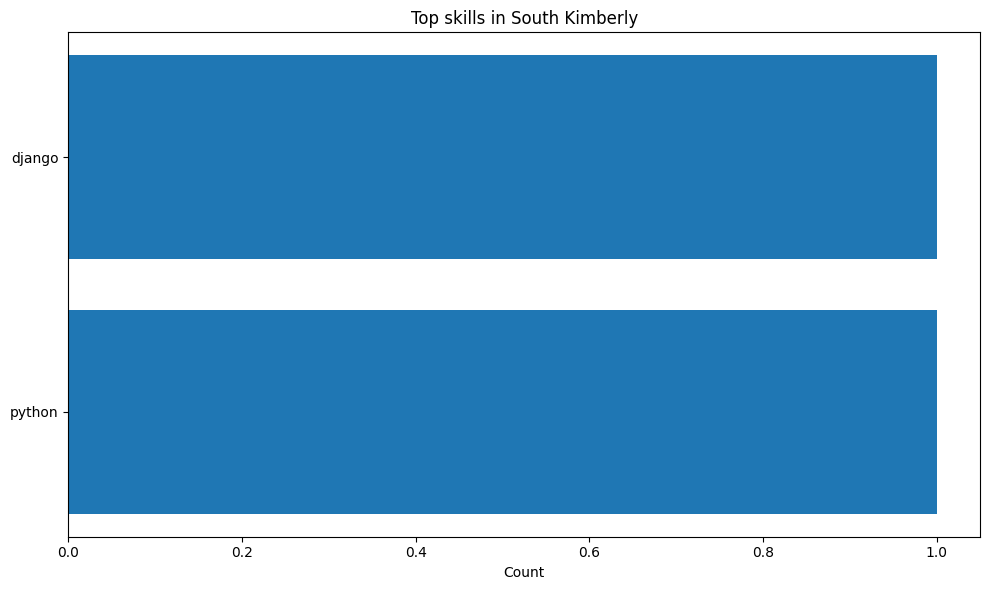

In [22]:
# explode to one skill per row
exp = df.explode("skills_found")
exp = exp.dropna(subset=["skills_found", "city"])

# choose a city you want to see
city = exp["city"].value_counts().index[0]  # most frequent city
city_data = (
    exp[exp["city"] == city]["skills_found"]
    .value_counts()
    .head(15)
)

plt.figure(figsize=(10,6))
plt.barh(city_data.index, city_data.values)
plt.gca().invert_yaxis()
plt.title(f"Top skills in {city}")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


Top cities by number of jobs

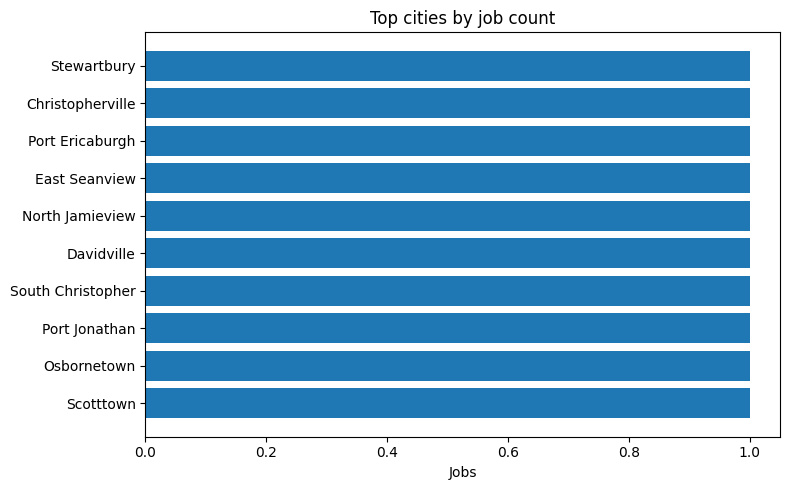

In [23]:
city_counts = df["city"].value_counts().head(10)
plt.figure(figsize=(8,5))
plt.barh(city_counts.index, city_counts.values)
plt.gca().invert_yaxis()
plt.title("Top cities by job count")
plt.xlabel("Jobs")
plt.tight_layout()
plt.show()
